## Imports

In [1]:
import copy
import os
import os.path as osp
import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import timm
import torch

from pyproj import Proj, transform
from torchgeo.models import ResNet18_Weights
from osgeo import gdal
from PIL import Image, ImageDraw
from sklearn.preprocessing import minmax_scale

/mnt/e/WORK_DL/hack_ldt/solution/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
inProj = Proj(init='epsg:32637')
outProj = Proj(init='epsg:32637')
x1,y1 = -11705274.6374,4826473.6922
x2,y2 = transform(inProj,outProj,x1,y1)
print(x2,y2)

/mnt/e/WORK_DL/hack_ldt/solution/venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/mnt/e/WORK_DL/hack_ldt/solution/venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_31885/1692107265.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

-105.15027111593008 39.72785727727917


In [8]:
corner = np.array([
    [1748,1623],
    [1876,1623],
    [1876,1750],
    [1749,1749]
])

In [10]:
src = gdal.Open("/mnt/e/WORK_DL/datasets/18. Sitronics/1_20/crop_0_0_0000.tif")
ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
lrx = ulx + (src.RasterXSize * xres)
lry = uly + (src.RasterYSize * yres)
print(ulx, xres, xskew, uly, yskew, yres)
print(lrx, lry)

0.0 0.1 0.0 0.0 0.0 0.1
23.3 21.1


In [5]:
src = gdal.Open("/mnt/e/WORK_DL/datasets/18. Sitronics/layouts/layout_2021-06-15.tif")
ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
lrx = ulx + (src.RasterXSize * xres)
lry = uly + (src.RasterYSize * yres)

In [6]:
ulx, xres, xskew, uly, yskew, yres

(399960.0, 10.0, 0.0, 5800020.0, 0.0, -10.0)

In [7]:
lrx, lry

(509760.0, 5690220.0)

## CONSTANTS

In [ ]:
LAYOUTS_DIR = "/mnt/e/WORK_DL/datasets/18. Sitronics/layouts"
CROPS_DIR = "/mnt/e/WORK_DL/datasets/18. Sitronics/1_20"

In [ ]:
from mpire import WorkerPool
from utils.processing_utils import (
    filter_matches,
    preprocessing_v1,
    postprocessing_v1,
    postprocessing_v2,
    read_test_data,
    save_crop,
    read_layout_by_ij,
    read_tif,
    save_coordinates
)

class cfg:
    def __init__(self) -> None:
        self.STEP = 250

CFG = cfg()

tmp_crops_dir = "/mnt/e/WORK_DL/datasets/18. Sitronics/crop_one_layout"
layout_img_path = "/mnt/e/WORK_DL/datasets/18. Sitronics/layouts/layout_2021-06-15.tif"
layout_img = read_tif(layout_img_path, False)
layout_h, layout_w = layout_img.shape[:2]
rot_mat = cv2.getRotationMatrix2D((layout_w // 2, layout_h // 2), 60, 1.0)
layout_img = cv2.warpAffine(layout_img, rot_mat,(layout_w, layout_h))
shared_objects = tmp_crops_dir, layout_img
layout_h, layout_w = layout_img.shape[:2]
ij_list = [[[i, j], CFG.STEP] for i in range(layout_h // CFG.STEP + int(layout_h % CFG.STEP != 0)) for j in range(layout_w // CFG.STEP + int(layout_w % CFG.STEP != 0))][::200]
with WorkerPool(n_jobs=8, shared_objects=shared_objects) as pool:
    pool.map_unordered(save_crop, ij_list, progress_bar=True)

100%|██████████| 10/10 [00:00<00:00, 239.43it/s]


## Utils

In [ ]:
def read_tif_rgbir(tif_file):
    dataset = gdal.Open(tif_file)
    r = dataset.GetRasterBand(1).ReadAsArray()
    g = dataset.GetRasterBand(2).ReadAsArray()
    b = dataset.GetRasterBand(3).ReadAsArray()
    ir = dataset.GetRasterBand(4).ReadAsArray()

    return r, g, b, ir

def show_tif(tif_file):
    dataset = gdal.Open(tif_file)
    array = dataset.GetRasterBand(1).ReadAsArray()

    plt.figure(figsize=(10, 10))
    plt.imshow(array)
    plt.colorbar()

def normilize(img):
    norm = np.linalg.norm(img)
    return img/norm  # normalized matrix

## Visulalise layouts

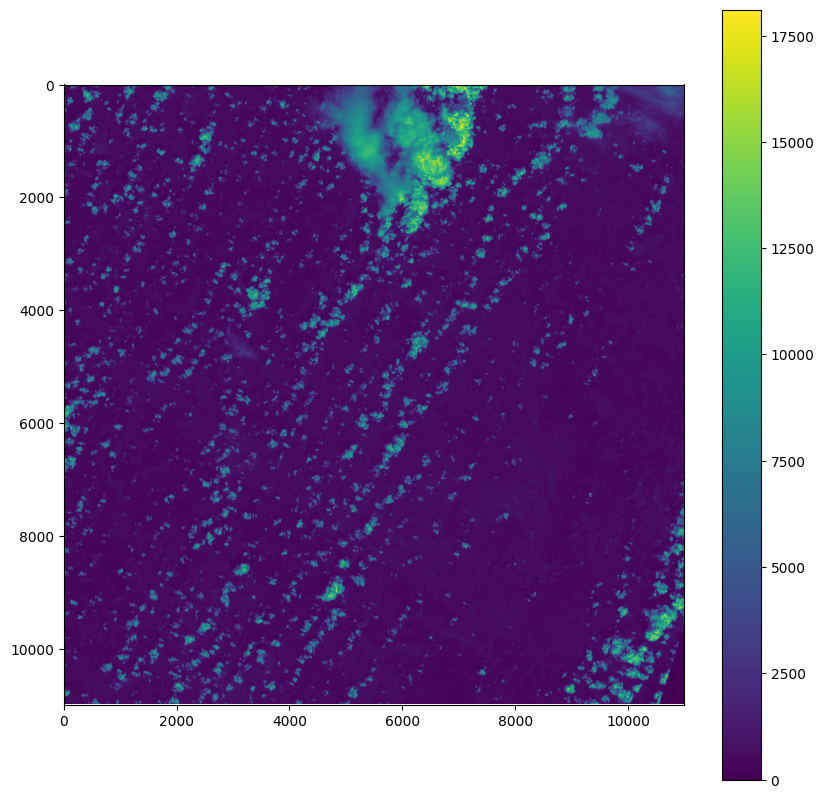

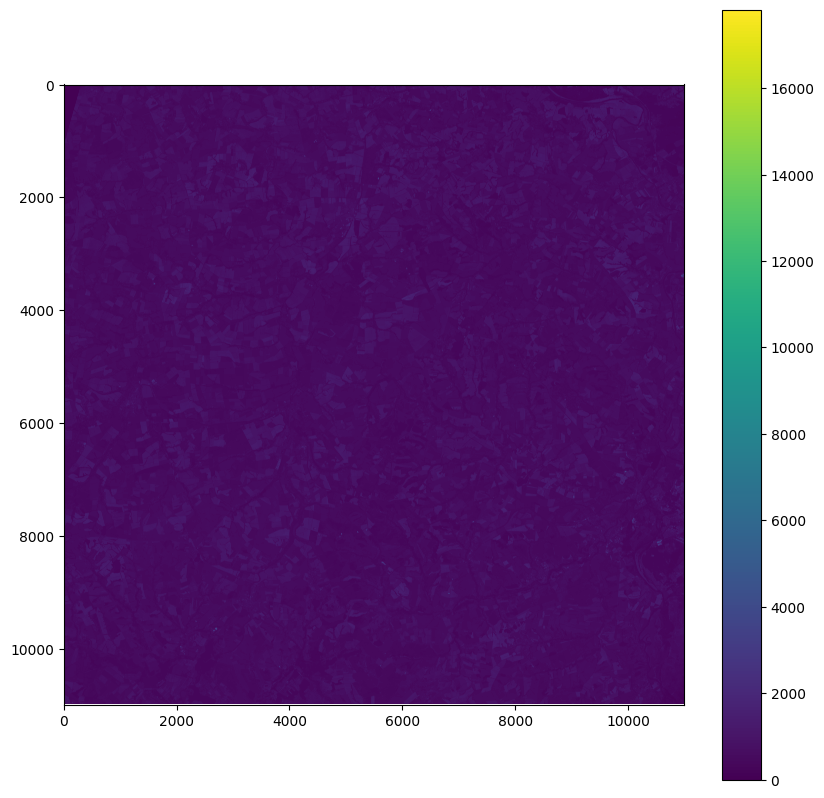

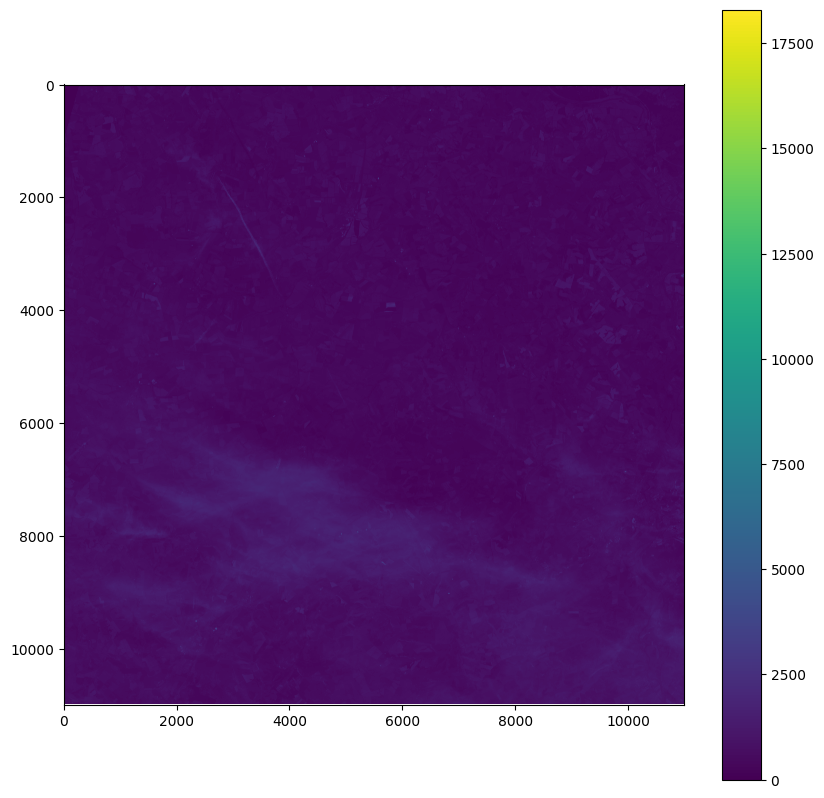

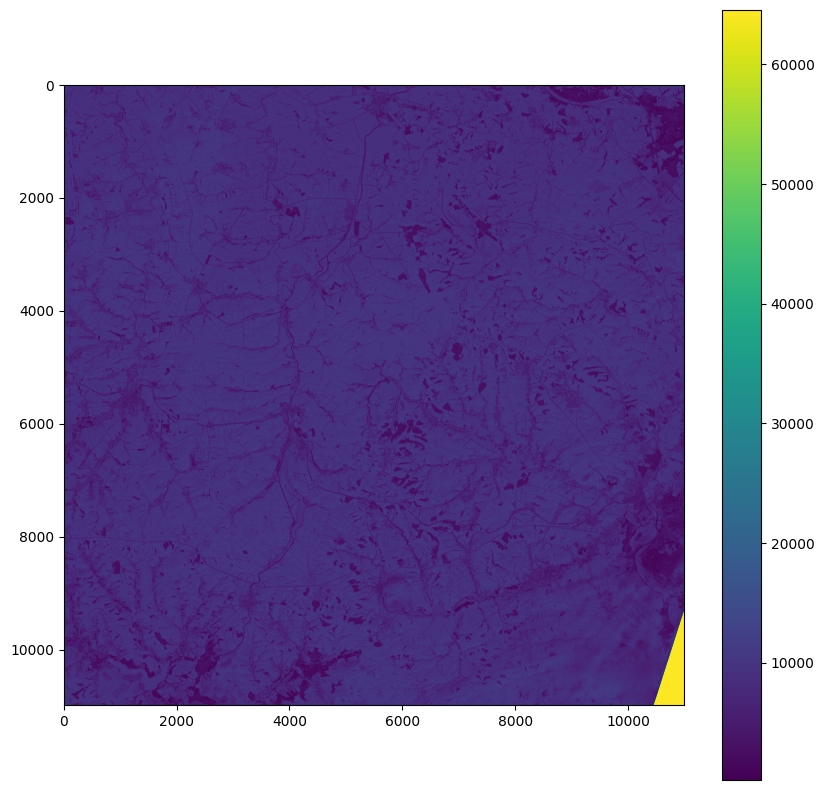

In [ ]:
for path in glob.glob(osp.join(LAYOUTS_DIR, "*.tif")):
    show_tif(path)

## Visualise crops

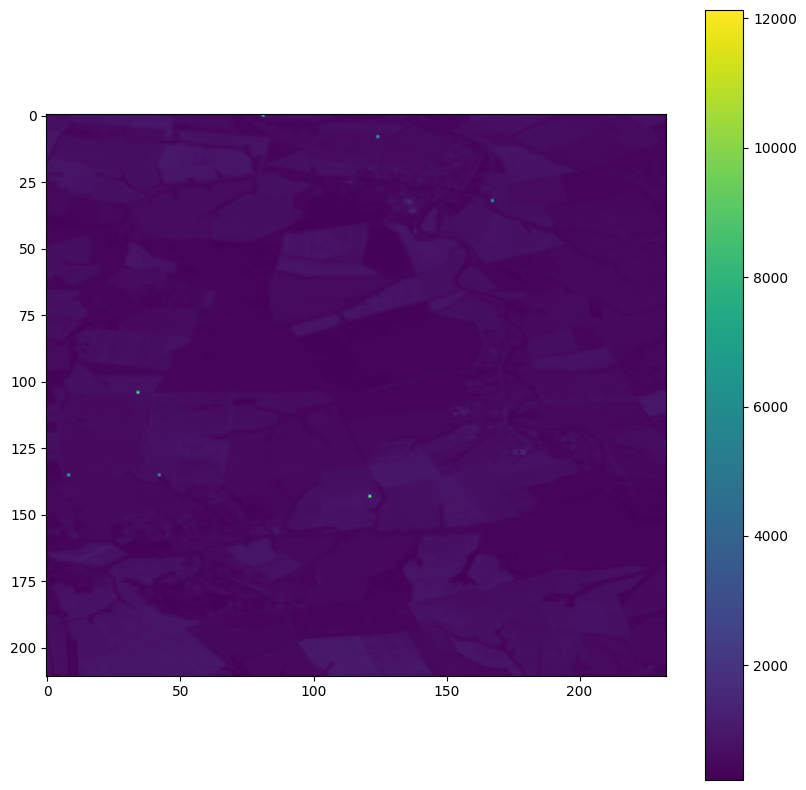

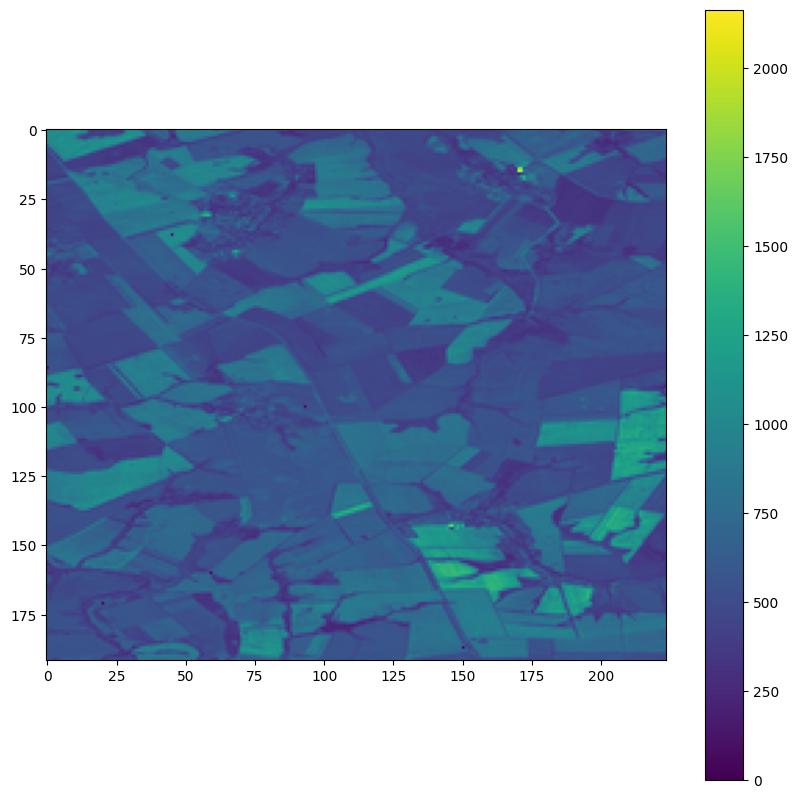

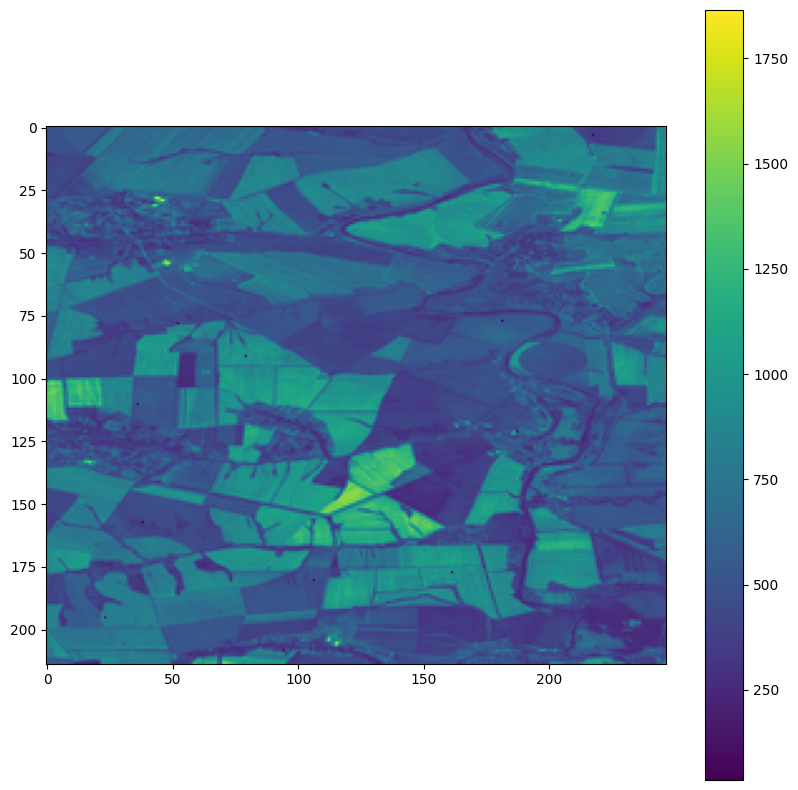

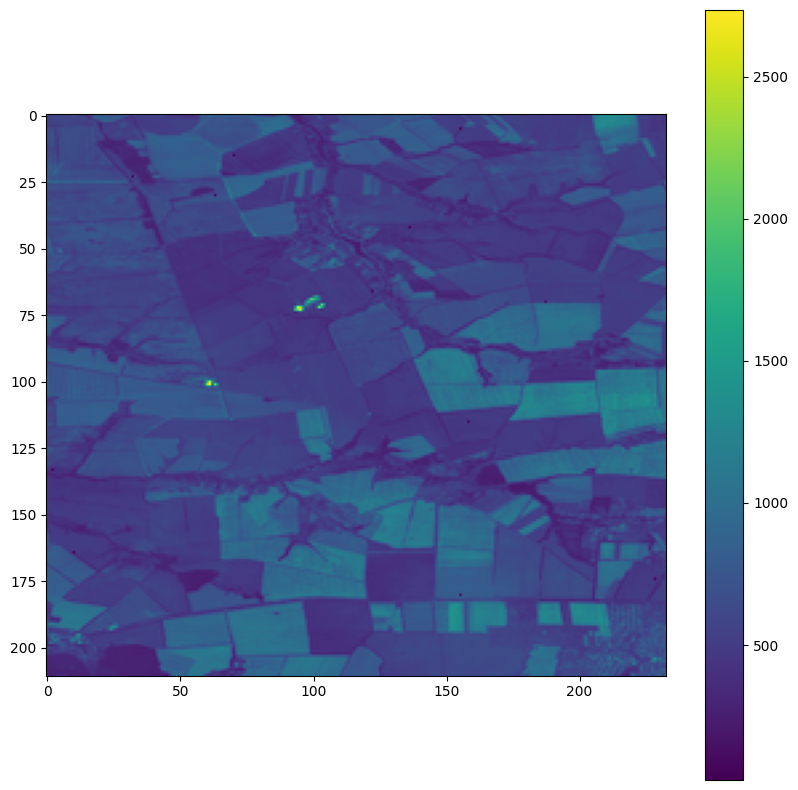

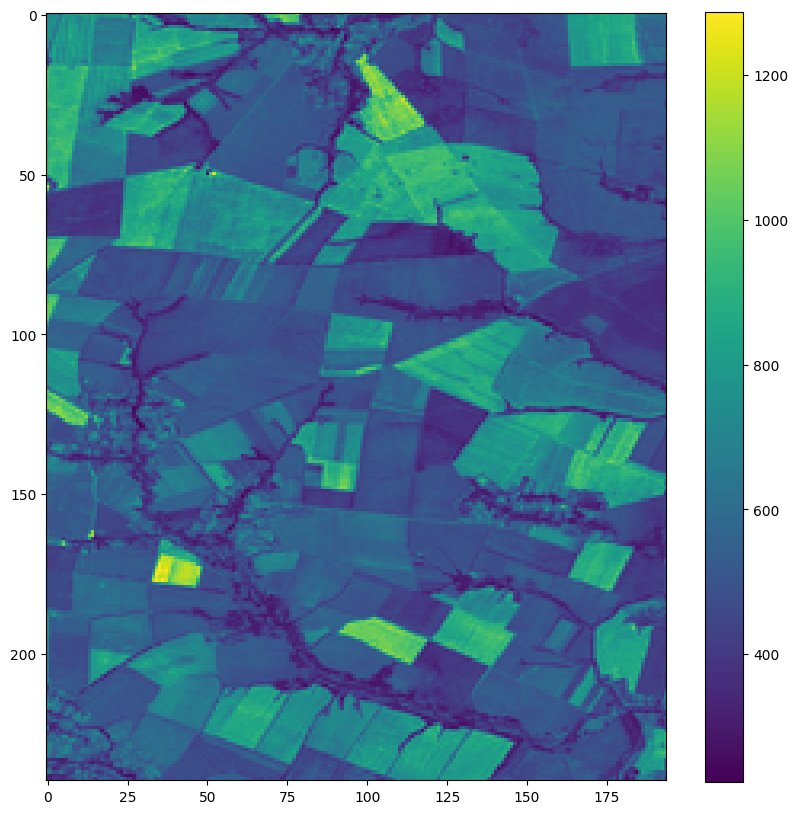

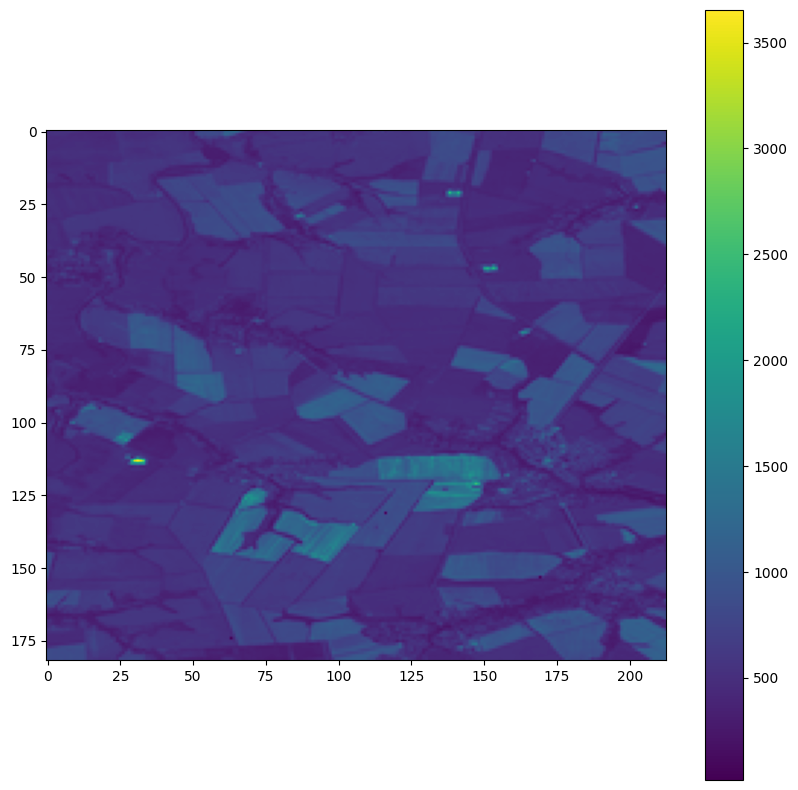

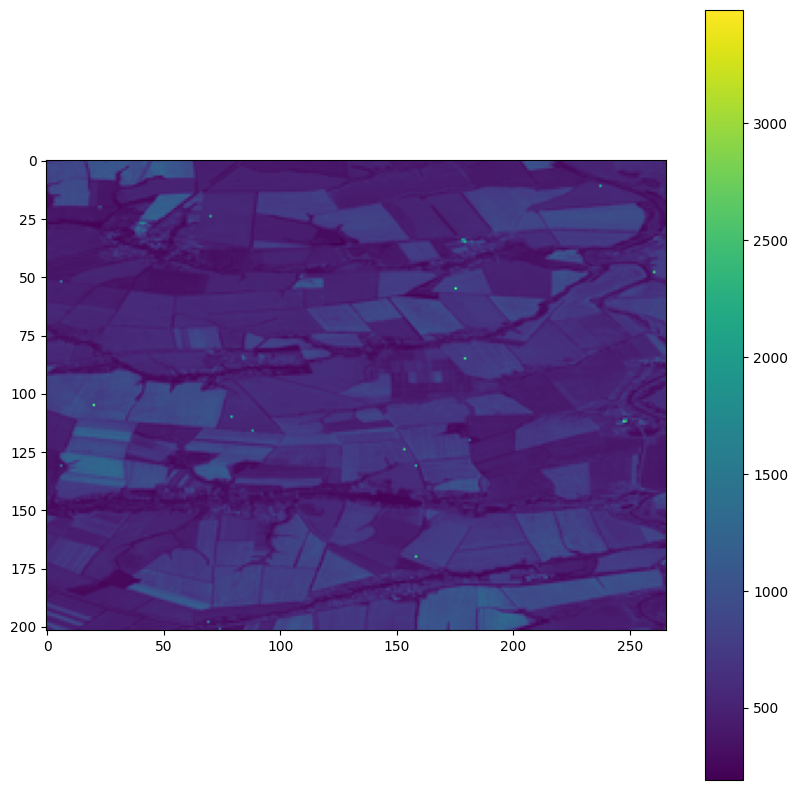

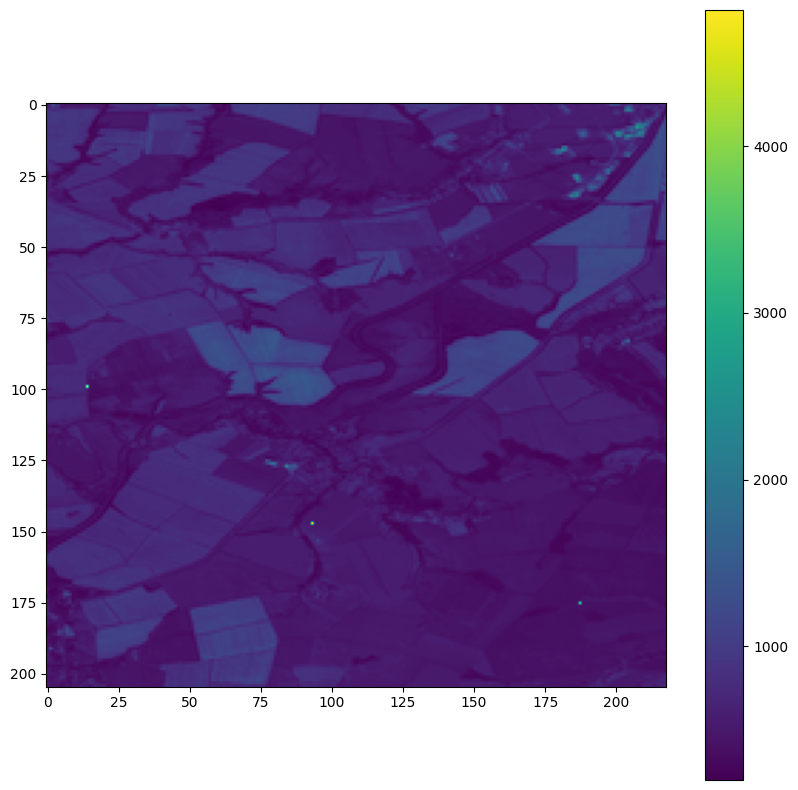

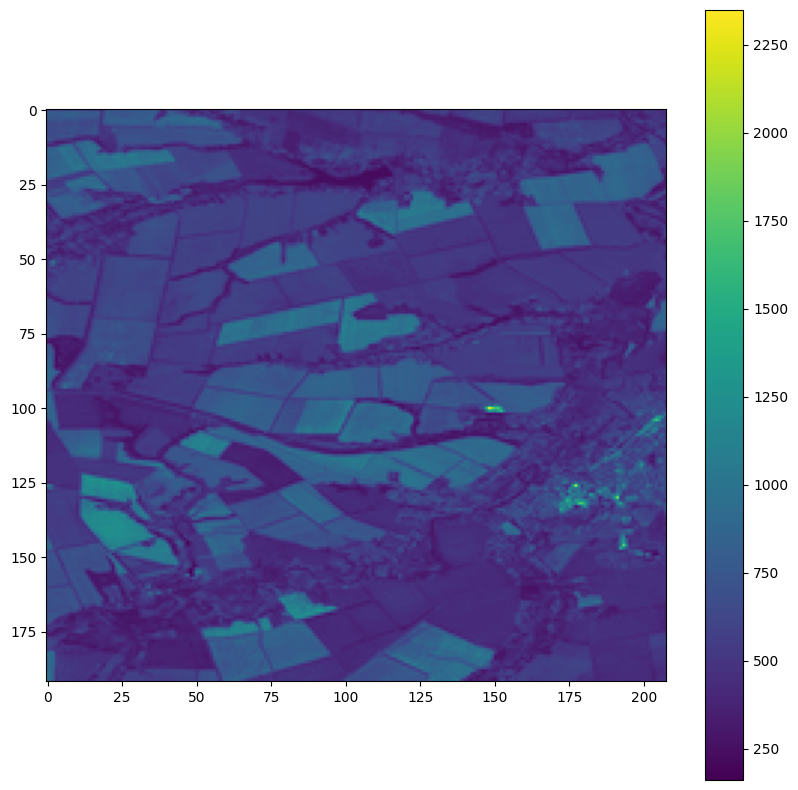

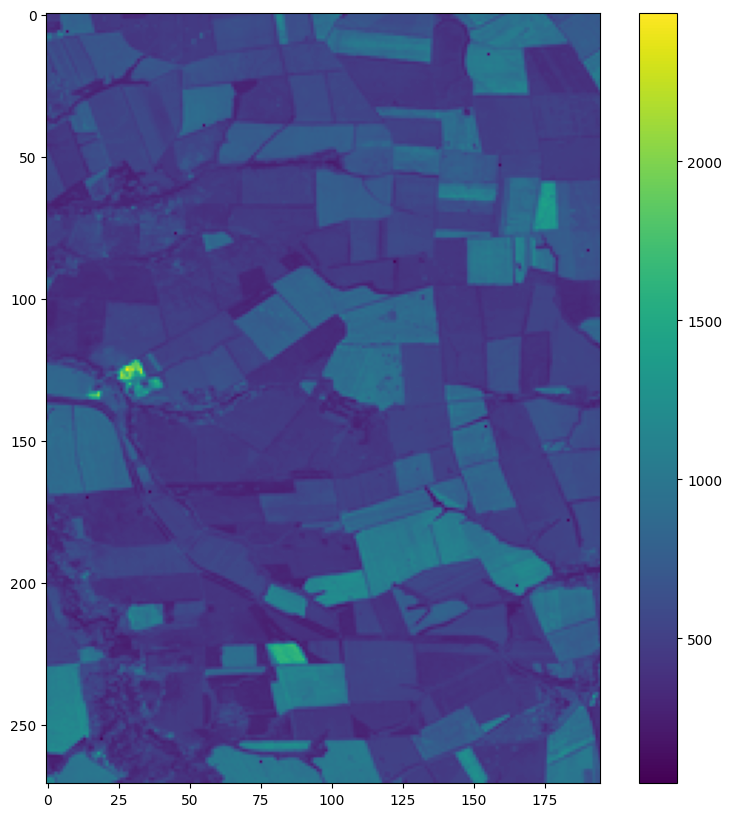

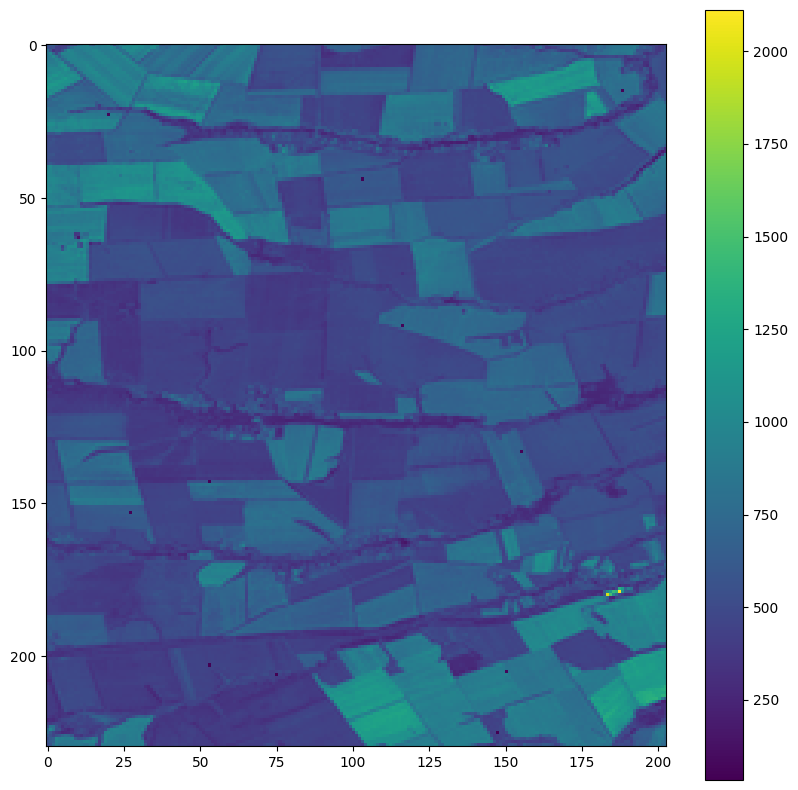

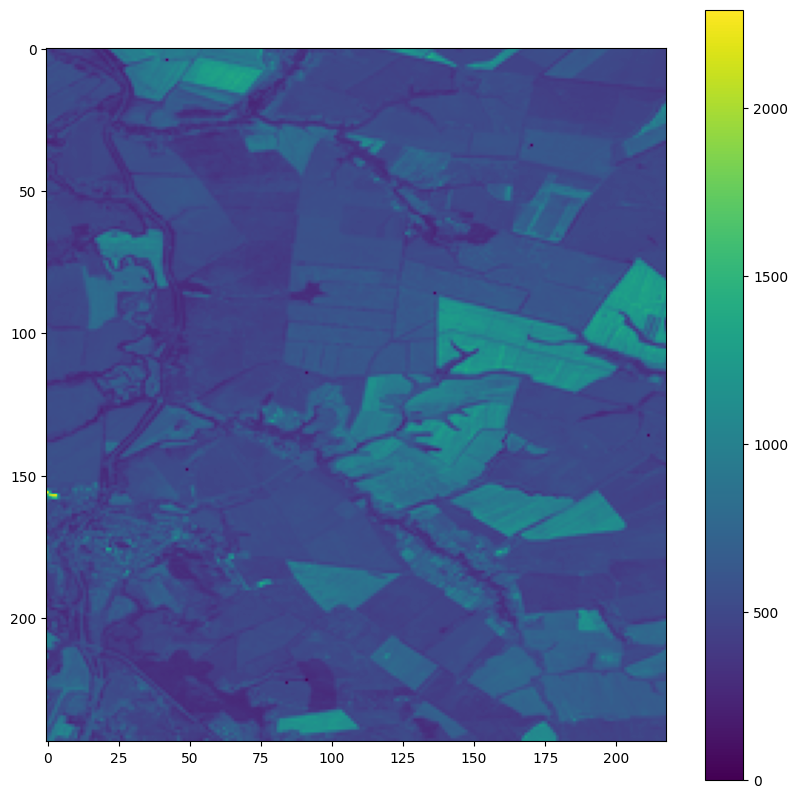

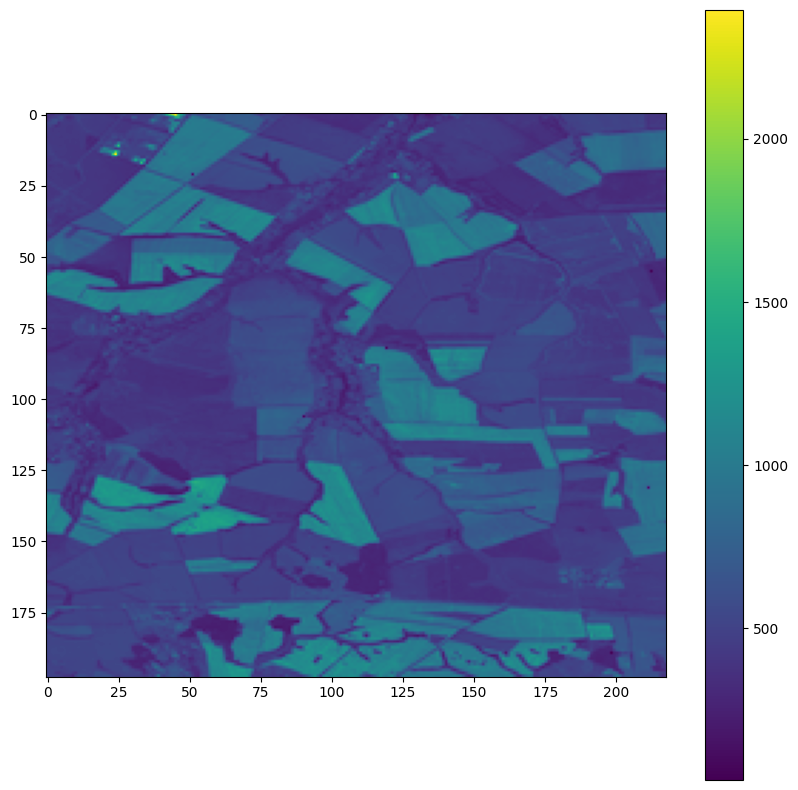

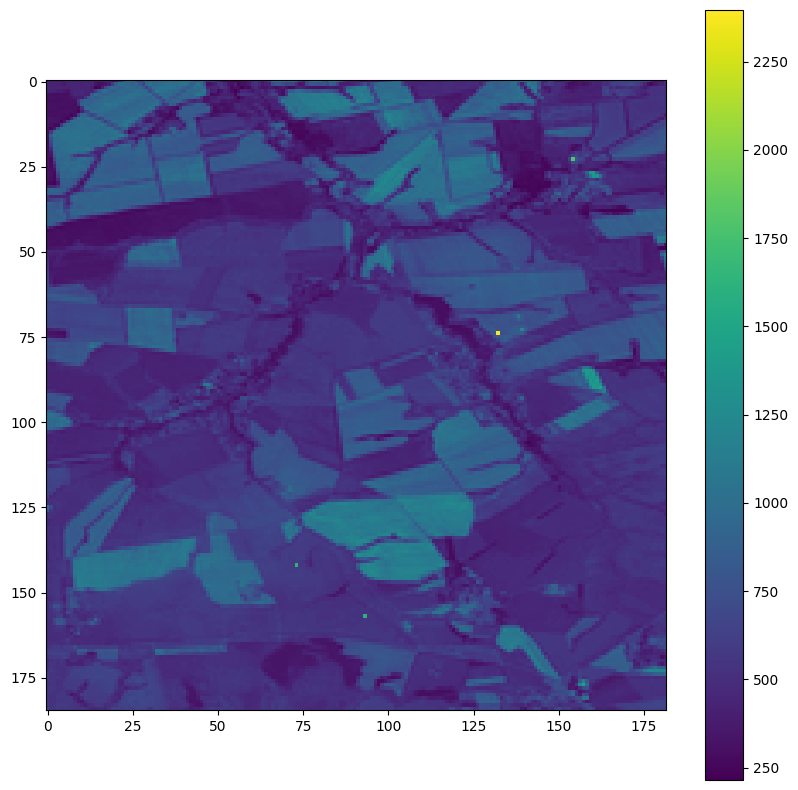

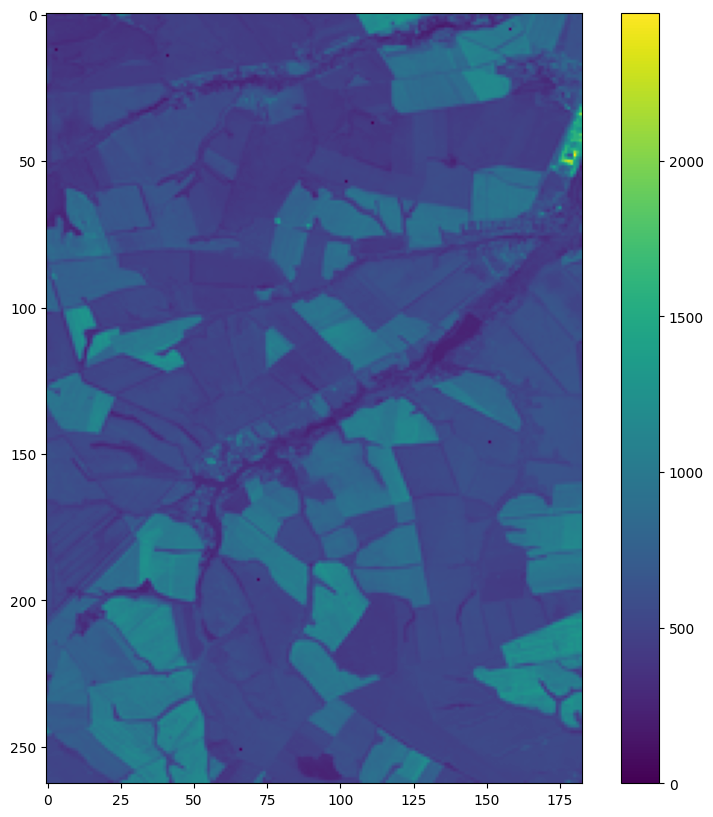

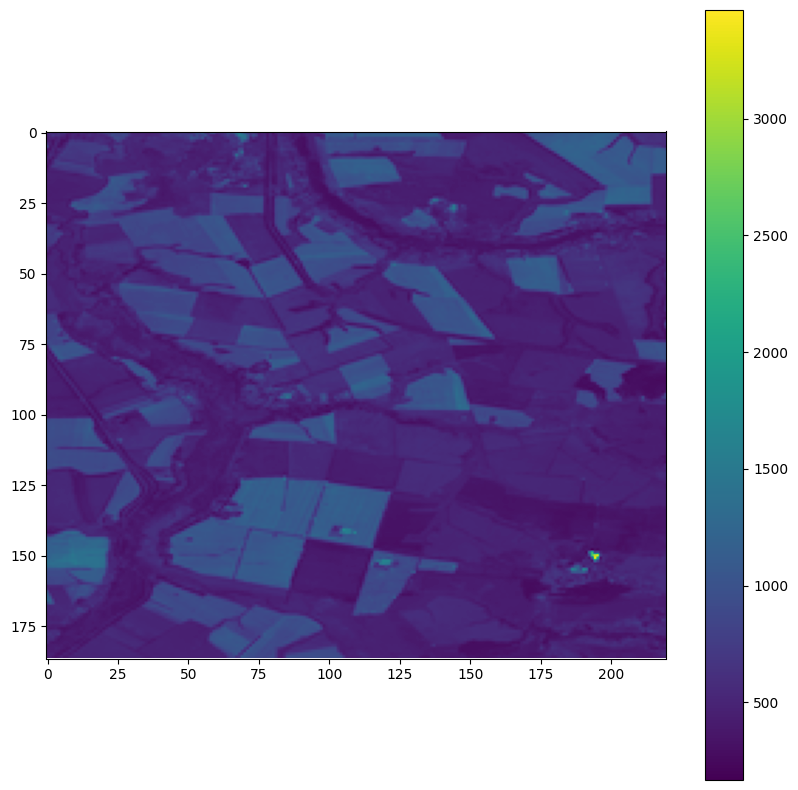

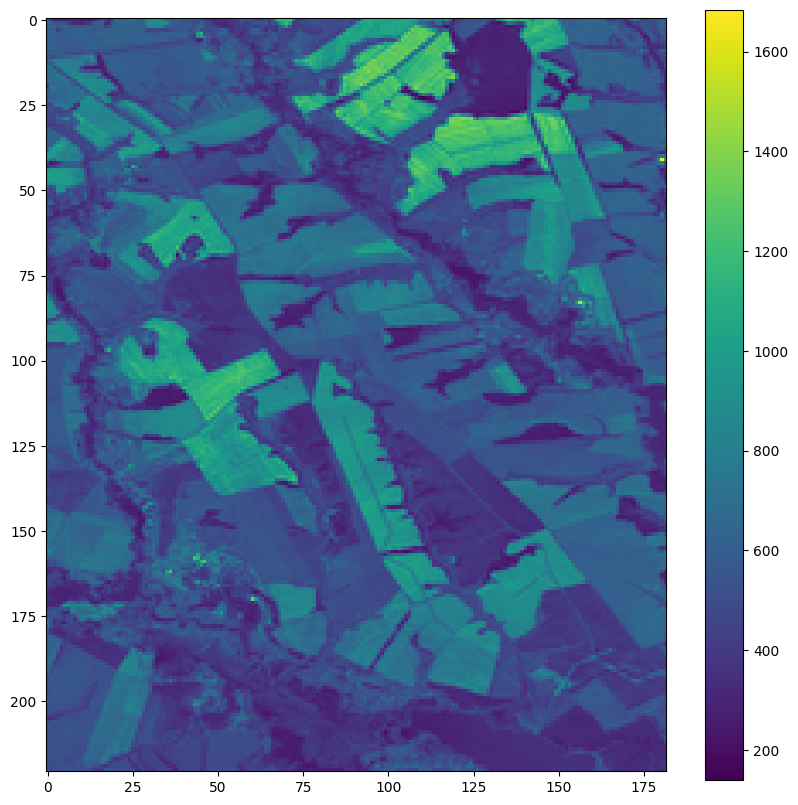

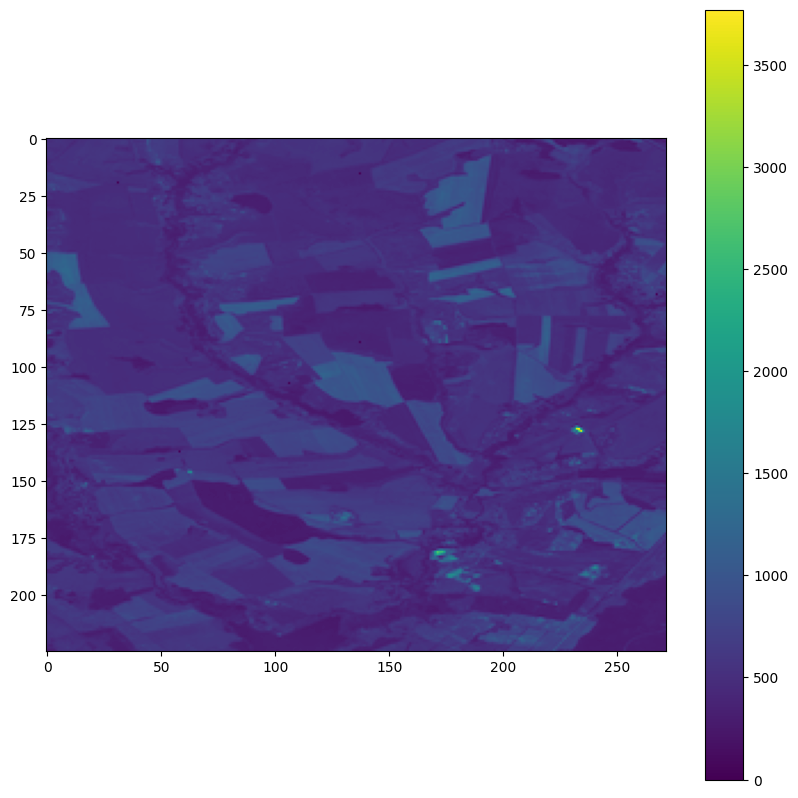

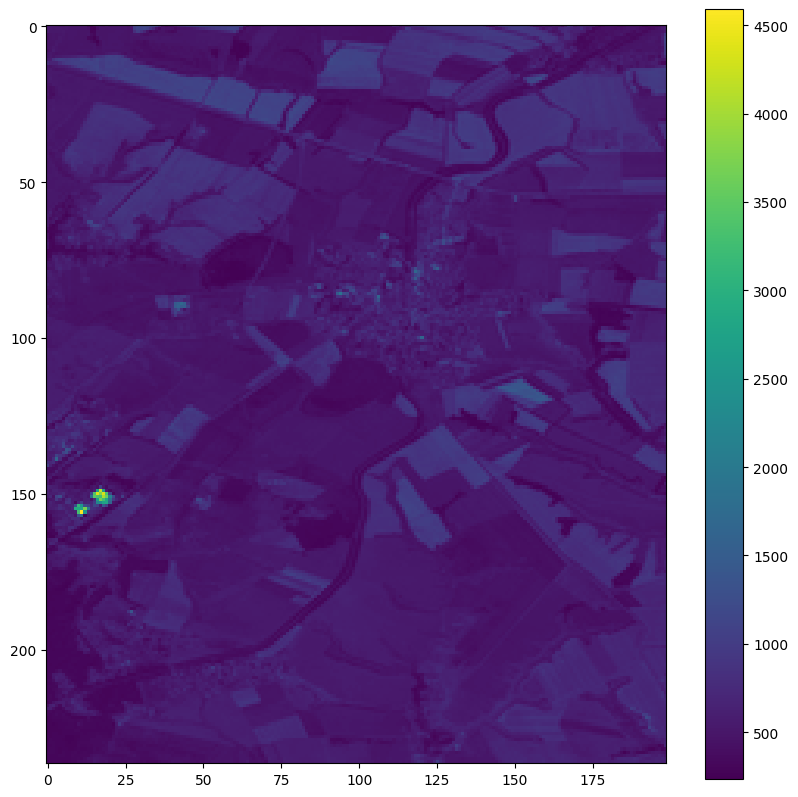

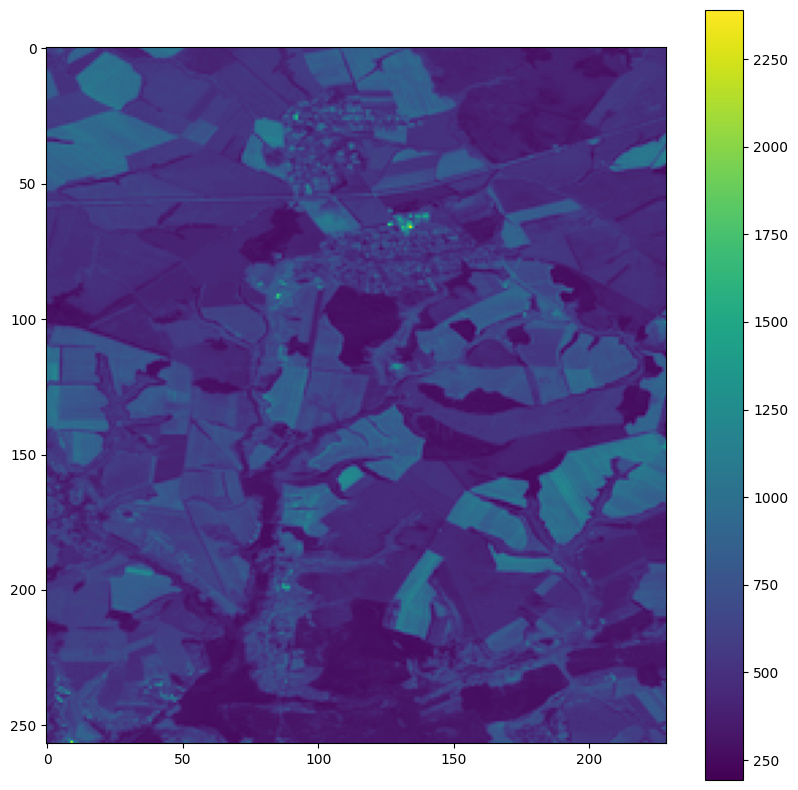

In [ ]:
for path in glob.glob(osp.join(CROPS_DIR, "*.tif")):
    show_tif(path)

## EDA

In [ ]:
tif_file_crop = "/mnt/e/WORK_DL/datasets/18. Sitronics/1_20/crop_0_0_0000.tif"
tif_file_layout = "/mnt/e/WORK_DL/datasets/18. Sitronics/layouts/layout_2021-06-15.tif"

In [ ]:
raster = gdal.Open(tif_file_crop)

In [ ]:
img_width,img_height = raster.RasterXSize,raster.RasterYSize
img_width,img_height

(10980, 10980)

In [ ]:
geotransform = raster.GetGeoTransform()
x_min = geotransform[0]
y_max = geotransform[3]
pixel_width = geotransform[1]
pixel_height = geotransform[5]
rotation = geotransform[2]
geotransform

(0.0, 0.1, 0.0, 0.0, 0.0, 0.1)

In [ ]:
raster.GetRasterBand(1).ComputeRasterMinMax()

(1.0, 18112.0)

## Feature extraction SIFT

In [ ]:
# create SIFT feature extractor
sift = cv2.SIFT_create()

In [ ]:
raster = gdal.Open(tif_file_crop)
img = raster.ReadAsArray()
print(img.shape)
image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
keypoints, descriptors = sift.detectAndCompute(image8bit, None)
keypoints, descriptors

(4, 211, 233)


((), None)

In [ ]:
kp = sift.detect(img[..., 0],None)
kp

()

## Feature extraction ORB

In [ ]:
# Initialize the ORB detector algorithm
orb = cv2.ORB_create()

In [ ]:
crop_raster = gdal.Open(tif_file_crop)
layout_raster = gdal.Open(tif_file_layout)

crop_img = crop_raster.ReadAsArray().transpose(1, 2, 0)
layout_img = layout_raster.ReadAsArray().transpose(1, 2, 0)

In [ ]:
crop_img = cv2.imread(tif_file_crop, cv2.IMREAD_GRAYSCALE)
layout_img = cv2.imread(tif_file_layout, cv2.IMREAD_GRAYSCALE)
layout_img = layout_img[:1000, :1000]
print(crop_img.shape, layout_img.shape)
print(crop_img.min(), crop_img.max())
print(layout_img.min(), layout_img.max())

(211, 233) (1000, 1000)
0 255
0 64


In [ ]:
for i in range(4):
    crop_img[..., i] = minmax_scale(crop_img[..., i], (0, 1))
    layout_img[..., i] = minmax_scale(layout_img[..., i], (0, 1))

print(crop_img.min(), crop_img.max())
print(layout_img.min(), layout_img.max())

0 255
0 64


In [ ]:
# Now detect the keypoints and compute
# the descriptors for the query image
# and train image
queryKeypoints, queryDescriptors = orb.detectAndCompute(layout_img,None)
trainKeypoints, trainDescriptors = orb.detectAndCompute(crop_img,None)
len(queryKeypoints), len(trainKeypoints)

(2, 417)

In [ ]:
queryDescriptors.shape, trainDescriptors.shape

((2, 32), (417, 32))

In [ ]:
# Initialize the Matcher for matching
# the keypoints and then match the
# keypoints
matcher = cv2.BFMatcher()
matches = matcher.match(queryDescriptors,trainDescriptors)
 
# draw the matches to the final image
# containing both the images the drawMatches()
# function takes both images and keypoints
# and outputs the matched query image with
# its train image
final_img = cv2.drawMatches(layout_img, queryKeypoints, 
crop_img, trainKeypoints, matches[:20],None)
 
final_img = cv2.resize(final_img, (1000,650))

# Show the final image
cv2.imwrite("table-sift.jpg", final_img)

True

In [ ]:
# draw the detected key points
sift_image = cv2.drawKeypoints(crop_img, trainKeypoints, crop_img)
# show the image
# cv2.imshow('image', sift_image)
# save the image
cv2.imwrite("table-sift.jpg", sift_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Feature extractor ResNet

In [ ]:
tif_file_crop = "/mnt/e/WORK_DL/datasets/18. Sitronics/1_20/crop_0_0_0000.tif"
tif_file_layout = "/mnt/e/WORK_DL/datasets/18. Sitronics/layouts/layout_2021-06-15.tif"

In [ ]:
raster = gdal.Open(tif_file_crop)
img = raster.ReadAsArray()[:-1, ...][None, ...]
img = torch.from_numpy(img) / 255
print(img.shape, img.dtype)

torch.Size([1, 3, 211, 233]) torch.float32


In [ ]:
num_features = 256
weights = ResNet18_Weights.SENTINEL2_RGB_MOCO
model = timm.create_model("resnet18", in_chans=weights.meta["in_chans"], num_classes=num_features)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [ ]:
model(img).shape

torch.Size([1, 256])

In [ ]:
layout_h = layout_w = 11000
step = 1000

In [ ]:
[[i, j] for i in range(layout_h // step) for j in range(layout_w // step)]

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [1, 0],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [1, 9],
 [1, 10],
 [2, 0],
 [2, 1],
 [2, 2],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 8],
 [2, 9],
 [2, 10],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 3],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 8],
 [3, 9],
 [3, 10],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3],
 [4, 4],
 [4, 5],
 [4, 6],
 [4, 7],
 [4, 8],
 [4, 9],
 [4, 10],
 [5, 0],
 [5, 1],
 [5, 2],
 [5, 3],
 [5, 4],
 [5, 5],
 [5, 6],
 [5, 7],
 [5, 8],
 [5, 9],
 [5, 10],
 [6, 0],
 [6, 1],
 [6, 2],
 [6, 3],
 [6, 4],
 [6, 5],
 [6, 6],
 [6, 7],
 [6, 8],
 [6, 9],
 [6, 10],
 [7, 0],
 [7, 1],
 [7, 2],
 [7, 3],
 [7, 4],
 [7, 5],
 [7, 6],
 [7, 7],
 [7, 8],
 [7, 9],
 [7, 10],
 [8, 0],
 [8, 1],
 [8, 2],
 [8, 3],
 [8, 4],
 [8, 5],
 [8, 6],
 [8, 7],
 [8, 8],
 [8, 9],
 [8, 10],
 [9, 0],
 [9, 1],
 [9, 2],
 [9, 3],
 [9, 4],
 [9, 5],
 [9, 6],
 [9, 7],
 [9, 8],
 [9, 9],
 [9, 10],
